<a href="https://www.kaggle.com/code/jwblackston/cfb-recruiting-and-nfl-draft-success?scriptVersionId=110725374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Rockstars or Flop-stars? Examining Recruit Star Rating and NFL Draft Success

by Walker Blackston, MSPH

![(Bryce Young, courtesy of my favorite site name I've ever seen: Whole Whog Sports)](http://https://wehco.media.clients.ellingtoncms.com/img/photos/2021/11/20/AP21324774626167_t800.jpg?90232451fbcadccc64a17de7521d859a8f88077d)

# Introduction
Collegiate and Professional football are **billion-dollar** industries in the United States. With increased use of analytics in game preparation, coaching, and even betting, scouting and evaluation of talent remain relatively nascent fields of study. The onset of name, image and likeness compensation (NIL) has only deepened program interest in attracting blue-chip talent to their school. [Reports](https://theathletic.com/3178558/2022/03/11/five-star-recruit-in-class-of-2023-signs-agreement-with-collective-that-could-pay-him-more-than-8-million/) have surfaced that some high-schoolers are bankrolling as much as ***$8,000,000*** for their commitment. Bryce Young of Alabama (pictured above) was the previous record holder before ever playing a snap for the Crimson Tide.   

The purpose of this notebook is to explore and analyze data for examining NFL draft success (defined as drafted in the first three rounds) by a player's high-school recruiting composite ratings (supplied by 247's composite score). In short, ***does someone's rating as a high-school player predict success down the line as a professional?*** Additionally, how much does collegiate performance impact success? Obviously pro scouts are interested in player's who perform in college, but can we quantify how much exactly that matters, how much we could chalk up to external factors (i.e., "intangibles" or even combine data)?

The data can be found in this notebook and read in as a csv. **Code to generate the final analytic dataframe can be found on [my corresponding github repo.](https://github.com/jwblackston/recruitDraftEvaluation)**  

*Note: this analysis is intended to serve as support for publication of a pending blog post to [CFB data.com](https://collegefootballdata.com/)*

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.graph_objects as go
import seaborn as sns
import time
import statsmodels.api as sm

start = time.time()

In [2]:
df = pd.read_csv('../input/recruit-draft-eval/dfComplete (2).csv')

# Exploratory Data Analysis

There are several ways to look at our data. Ultimately, we care most about what influences draft success - again, being drafted in rounds 1, 2 or 3. We should begin any analysis of declaring our assumptions. Some assumptions are hidden and others obvious, but my training as a statistician dictates I state them all as explicitly as I can.

### **Assumptions and Limitations:**
1) While the good folks at CFB data do an amazing job housing lots of data on college football, we are all humans and sometimes data can be recorded mistakenly. This could propogate errors throughout the analysis and we should be wary of this in making conclusions. 

2) Defining "success" in the draft is somewhat arbitrary on my part - one could argue being drafted *at all* is a success. I am considering a follow-up sensitivity analysis where a player is drafted in any round is considered successful. 

3) And last, a major limitation: while well trained in statistics, I am a novice to intermediate data science practicioner. These models and inferences are hypothesis generating at best and meant to serve as basis for beginning a discussion, not ending them. Just because I run a neural net and predict draft success, doesn't mean we crown 247 the king in evaluating HS talent. 

With that out of the way, let's look at our data!

In [3]:
df.head()

,ident,rank,name,recruit_year,comp_recruit_rating,stars,position,school,draft_grade,college,...,team,countablePlays,averagePPA.all,totalPPA.all,totalPPA.pass,totalPPA.rush,position.1,season,career_avgPPA,career_totalPPA
0,14811,15,Andre Debose,2009,0.9913,5,WR,Florida,30.0,Florida,...,Florida,7.0,-0.166,-1.163,-3.399,2.236,WR,2014.0,-0.166,-1.163
1,14814,19,Aaron Murray,2009,0.9900,5,DUAL,Georgia,62.0,Georgia,...,Georgia,352.0,0.336,118.289,107.423,10.866,QB,2013.0,0.336,118.289
2,14827,31,Tajh Boyd,2009,0.9840,5,PRO,Clemson,39.0,Clemson,...,Clemson,481.0,0.262,126.105,105.782,20.323,QB,2013.0,0.262,126.105
3,14848,52,Logan Thomas,2009,0.9719,4,PRO,Virginia Tech,61.0,Virginia Tech,...,Virginia Tech,483.0,0.231,111.505,114.490,-2.985,QB,2013.0,0.231,111.505
4,14877,87,AJ McCarron,2009,0.9594,4,PRO,Alabama,78.0,Alabama,...,Alabama,320.0,0.295,94.326,88.052,6.274,QB,2013.0,0.295,94.326


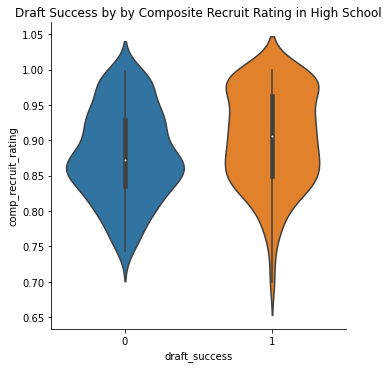

In [4]:
sns.catplot(x = 'draft_success',
           y = 'comp_recruit_rating',
           data = df, kind = 'violin')

plt.title('Draft Success by by Composite Recruit Rating in High School')
sns.set(rc={"figure.figsize": (20, 12)})
plt.show()

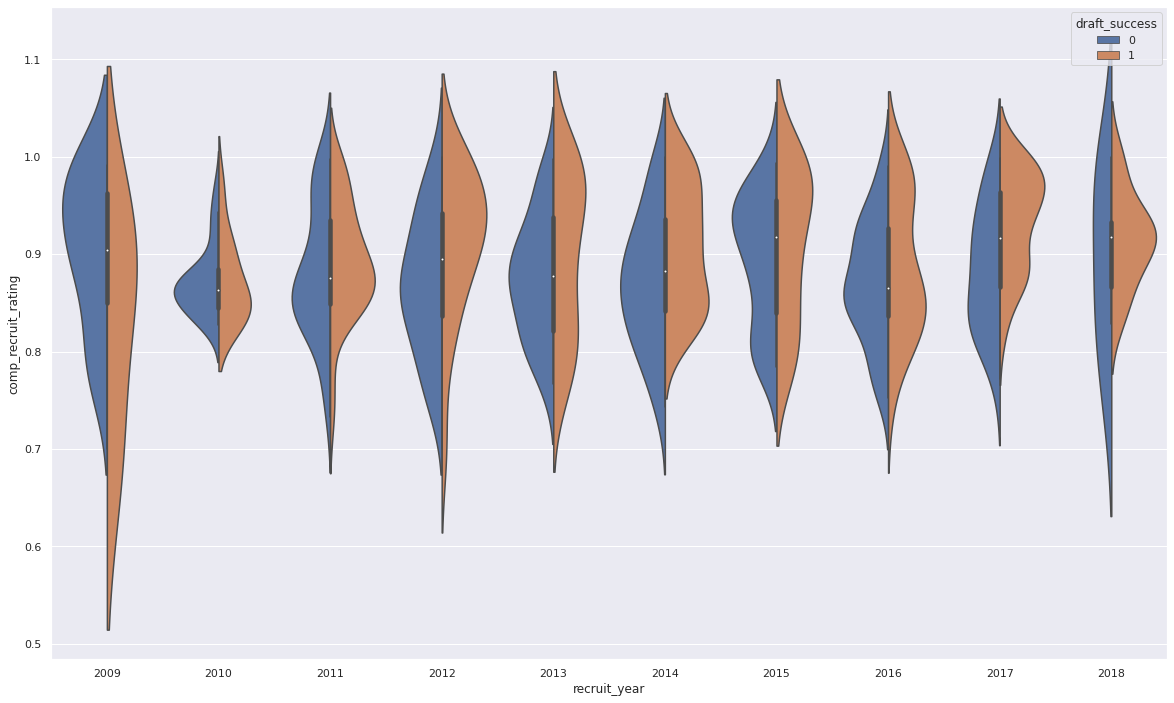

In [5]:
g = sns.violinplot(x = 'recruit_year',
                y = 'comp_recruit_rating',
                hue = 'draft_success', data = df, split = True)

plt.show()

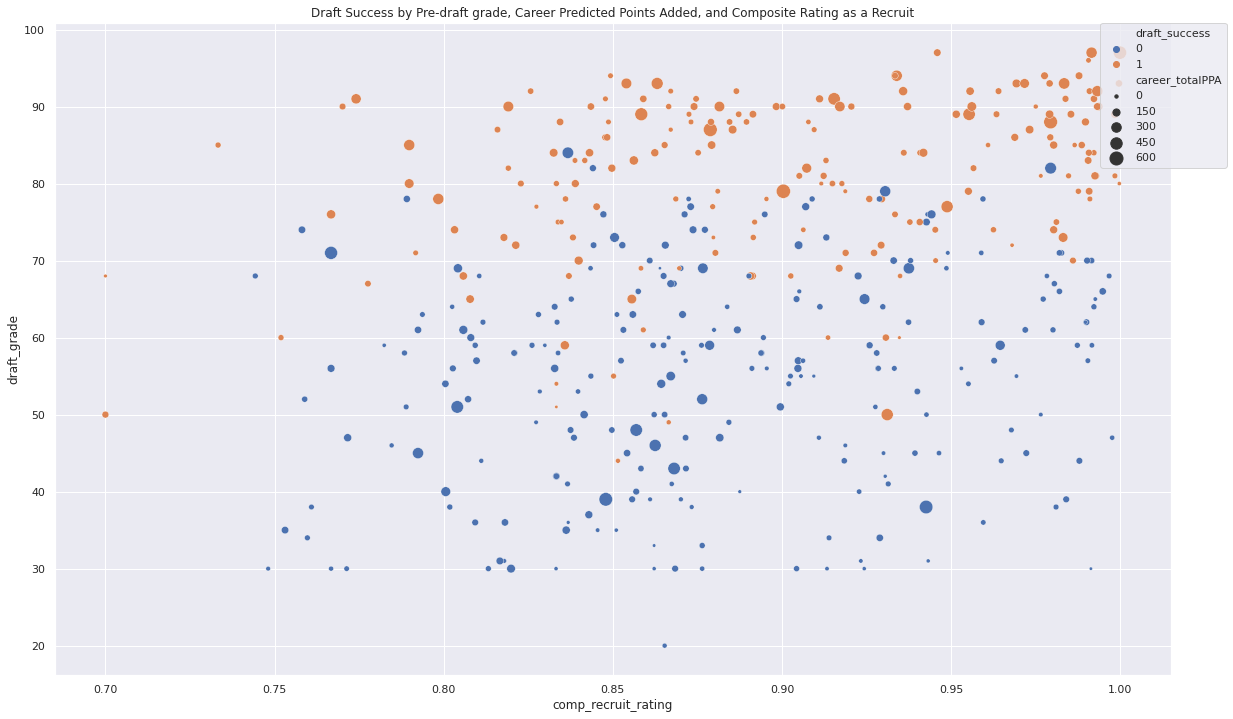

In [6]:
sns.scatterplot(
    x = 'comp_recruit_rating', 
    y = 'draft_grade', 
    data=df,
    hue = 'draft_success',
    size = 'career_totalPPA', sizes=(10, 200))
plt.title('Draft Success by Pre-draft grade, Career Predicted Points Added, and Composite Rating as a Recruit')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper right', borderaxespad=0)

sns.set(rc={"figure.figsize": (20, 12)})
plt.show()

If we make a simple model of recruit ratings by draft grade, we might expect to see something of a relationship. Let's do so here:

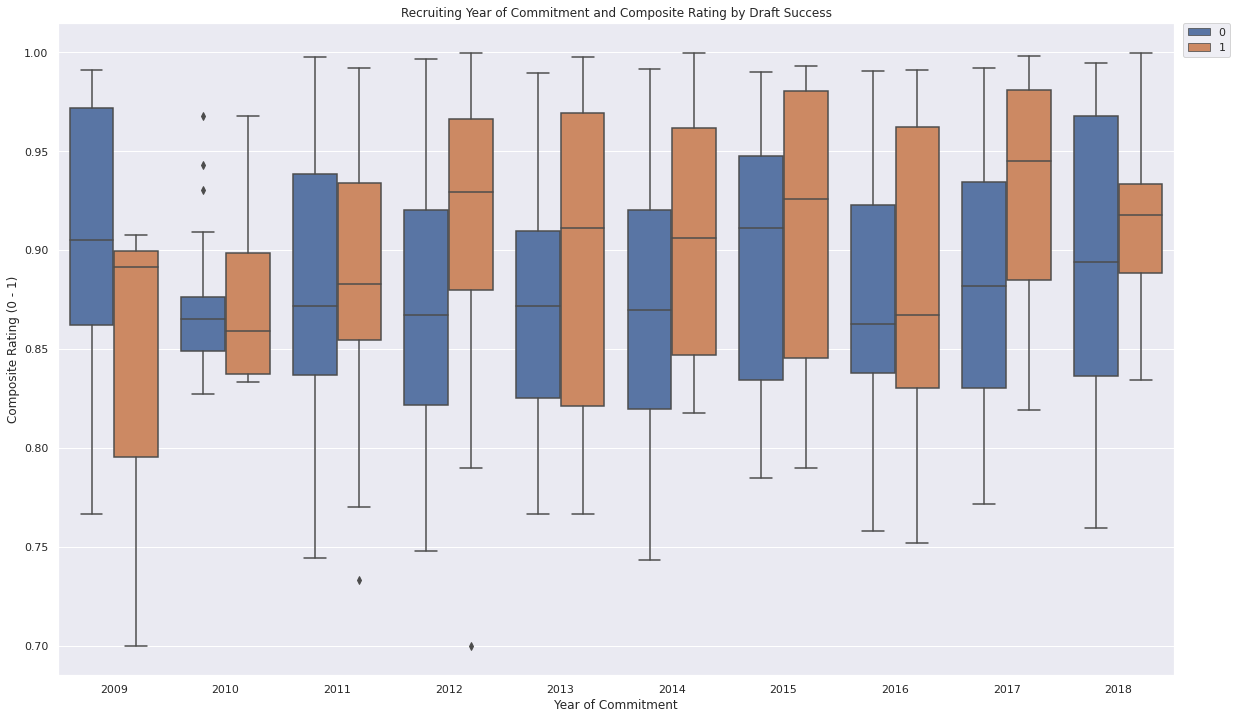

In [7]:
sns.boxplot(x = 'recruit_year', y = 'comp_recruit_rating',
          hue = 'draft_success', data = df)

plt.xlabel("Year of Commitment")
plt.ylabel("Composite Rating (0 - 1)")
plt.title("Recruiting Year of Commitment and Composite Rating by Draft Success")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper right', borderaxespad=0)
plt.show()

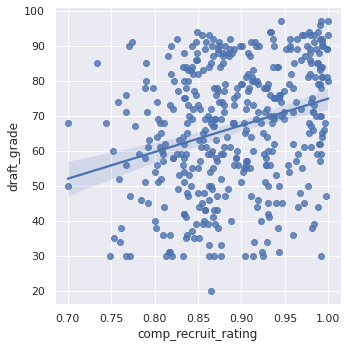

In [8]:
sns.lmplot(
    data = df,
    x = 'comp_recruit_rating',
    y = 'draft_grade')

sns.set(rc={'figure.figsize':(20,10)})
plt.show()

We want to check the model residuals, however, as it does seem to have a pretty wide spread in fit. Generally speaking though, draft grade is higher in players with higher ratings as recruits. 

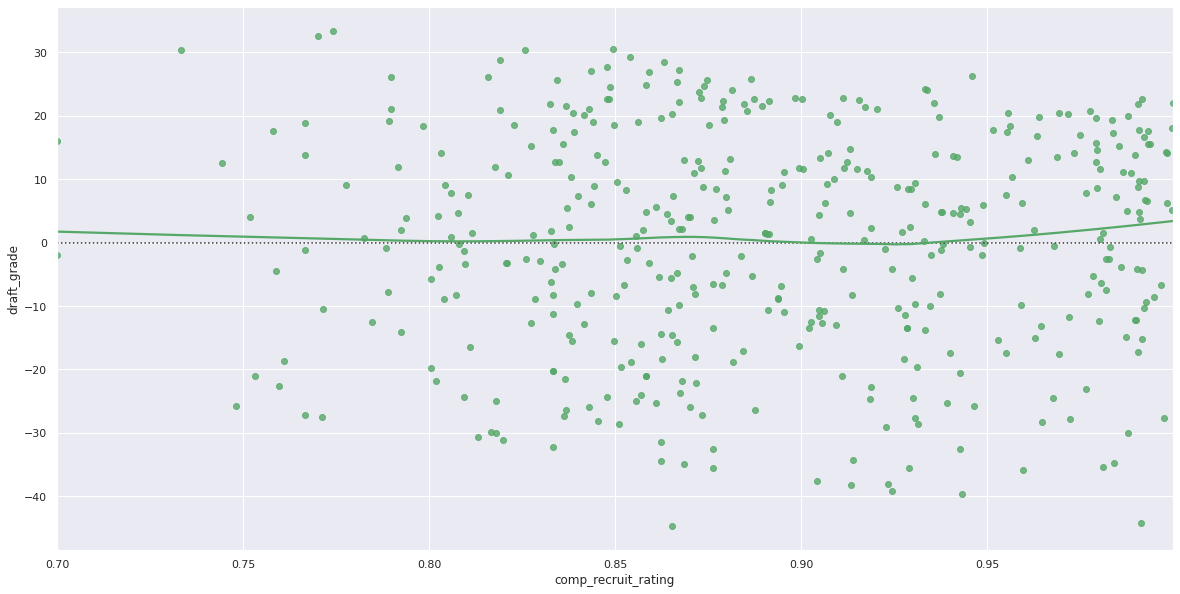

In [9]:
sns.residplot(x = 'comp_recruit_rating',
             y = 'draft_grade', data = df, lowess = True, color = "g")
plt.show()

Not too bad actually! We want to have relatively mirrored distribution of residuals around y = 0, which looks to be the case. Knowing this relationship is reasonably robust, what about each on our primary outcome, draft success?

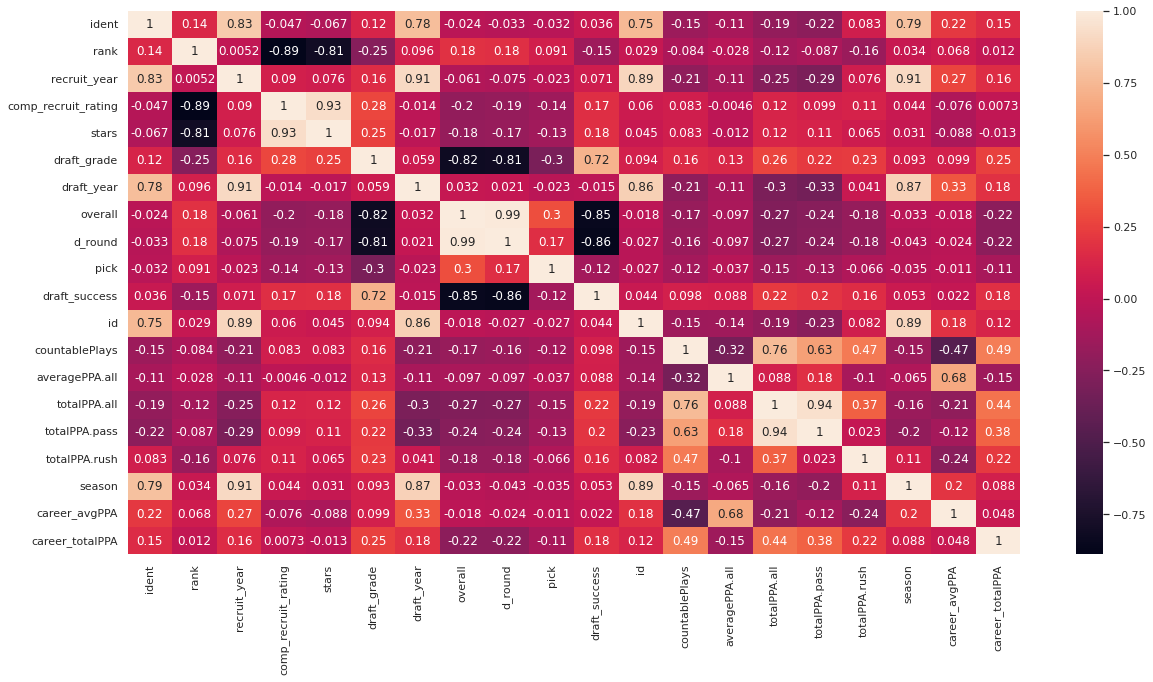

In [10]:
df_nums = df.select_dtypes(include = np.number)

heat = sns.heatmap(df_nums.corr(), annot=True)
sns.set(rc={"figure.figsize": (16, 10)})
plt.show()

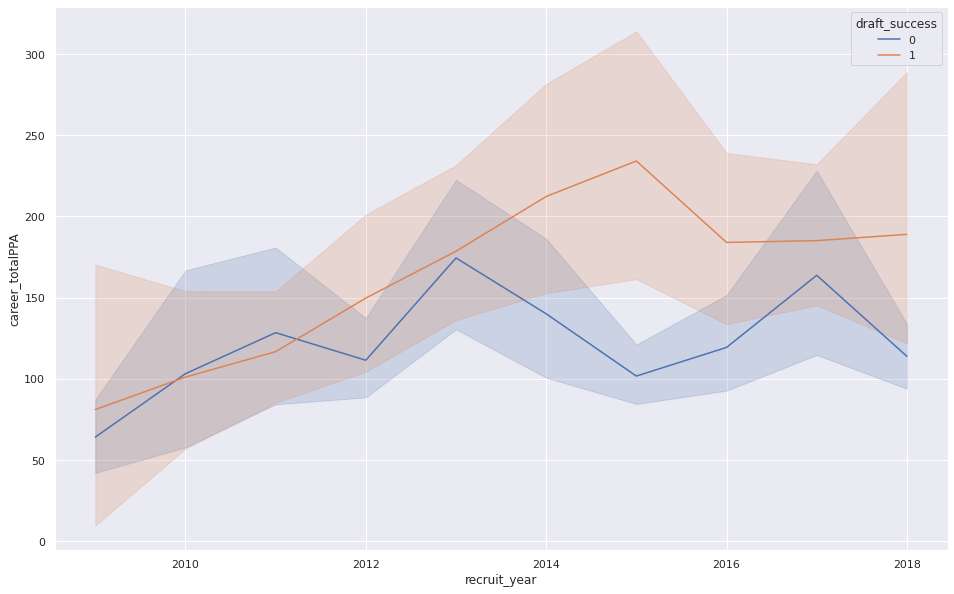

In [11]:
sns.lineplot(data = df,
            x = 'recruit_year',
            y = 'career_totalPPA',
            hue = 'draft_success')
plt.show()

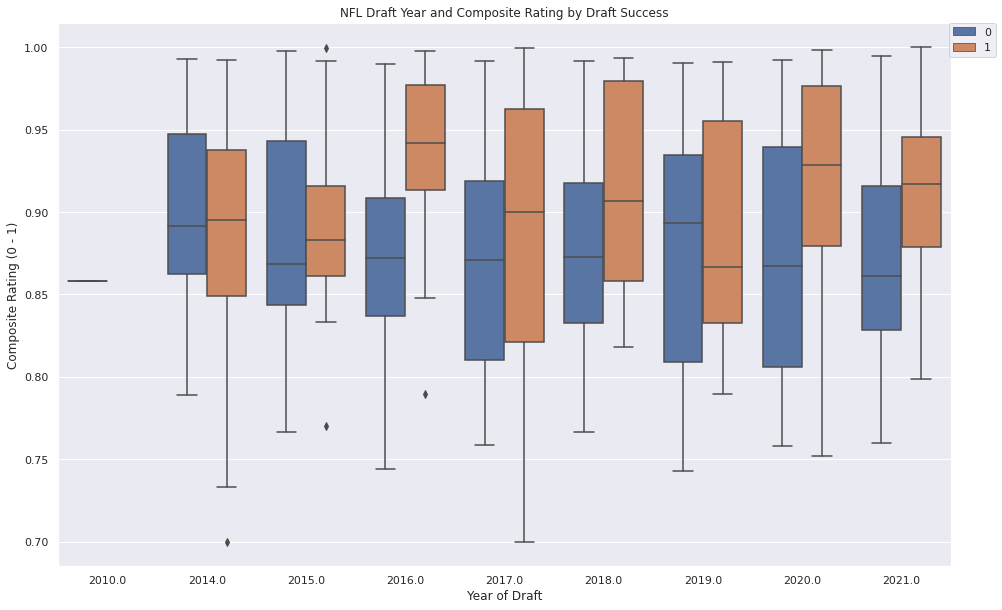

In [12]:
sns.boxplot(x = 'draft_year', y = 'comp_recruit_rating',
          hue = 'draft_success', data = df)

plt.xlabel("Year of Draft")
plt.ylabel("Composite Rating (0 - 1)")
plt.title("NFL Draft Year and Composite Rating by Draft Success")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper right', borderaxespad=0)
plt.show()

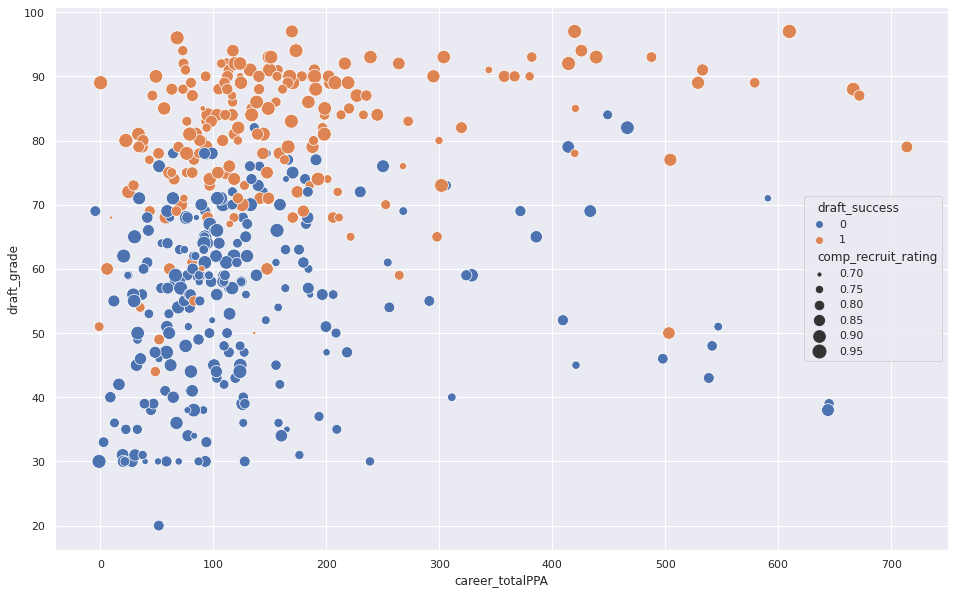

In [13]:
sns.scatterplot(
    data = df,
    x = 'career_totalPPA',
    y = 'draft_grade', 
    hue = 'draft_success', 
    size = 'comp_recruit_rating',  sizes=(10, 200))

sns.set(rc={"figure.figsize": (16, 10)})
plt.show()

From above, we see that there are some interesting relationships to explore. As always, there's a necessary caveat to include that correlation need not imply causation - just because something shows up here, doesn't mean that when we model out draft success it will be significant. Or even that they relate signficantly in the real world. This is a simple statistical relationship. 

With that out of the way, what do we see? 
1) A recruit's composite rating strongly correlates with stars (obvious), but **weakly** with draft success (*r*=0.18), and moderately with draft grade (*r* = 0.27). 

2) A similar pattern can be seen with star rating and draft success and grade. 

# Modeling:

I am going to continue being a good lil' statistician and state my hypotheses up front before jumping into any modeling. 

### *H0)* Composite recruiting ratings *will not* significantly predict a player's draft selection in the first, second and third rounds.

#### *H alternative)* Recruit's ratings *will* signficantly predict NFL draft success. 

In [14]:
# remove the target, draft success and store as target - drop other draft outcome related vars
from sklearn.model_selection import train_test_split

y = df['draft_success']
x = df.drop(['draft_success', 'overall', 'd_round', 'pick'], axis = 1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [15]:
X_train.head()

,position_y,position.1,ident,rank,recruit_year,comp_recruit_rating,stars,draft_year,id,countablePlays,averagePPA.all,totalPPA.all,season,career_avgPPA,career_totalPPA
45,Quarterback,QB,19068,1448,2010,0.8333,3,2014.0,503695.0,489.0,0.325,158.850,2013.0,0.325,158.850
264,Wide Receiver,WR,31887,27,2015,0.9879,5,2019.0,3915174.0,61.0,0.566,34.531,2015.0,2.807,123.574
4,Quarterback,QB,14877,87,2009,0.9594,4,2014.0,480215.0,320.0,0.295,94.326,2013.0,0.295,94.326
236,Tight End,TE,28675,471,2014,0.8715,3,2018.0,3122920.0,1.0,0.221,0.221,2014.0,2.285,53.855
431,Wide Receiver,WR,43136,229,2018,0.9123,4,2021.0,4372485.0,164.0,0.613,100.539,2018.0,1.423,139.103


In [16]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['position_y', 'position.1']


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#### Drop missing?

In [18]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
0.41534090909090915


#### One- hot encode?

In [19]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
0.41977272727272724


In [20]:
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(OH_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(OH_X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = OH_X_train.columns
imputed_X_valid.columns = OH_X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
0.41977272727272724


##### *No difference in MAE between non-imputed, one-hot and imputed.* To minimize bias, we ought to just stick to the set with missingness. Let's start building those models!

## Model 1: Logistic Regression

An oldie but a goodie - let's start with the most basic model we can implement for a classification problem. 

We've already pre-processed our data so we are good to go there. We just use our one-hot dataset to fit the regression and examine model diagnostics before making predictions on the test set. 

In [21]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

logreg = LogisticRegression(random_state=9, max_iter = 200)

# fit the model with data
logreg.fit(OH_X_train, y_train)

y_pred = logreg.predict(OH_X_valid)

print('Logistic model converged and fit.')

Logistic model converged and fit.


In [22]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[39,  8],
       [31, 10]])

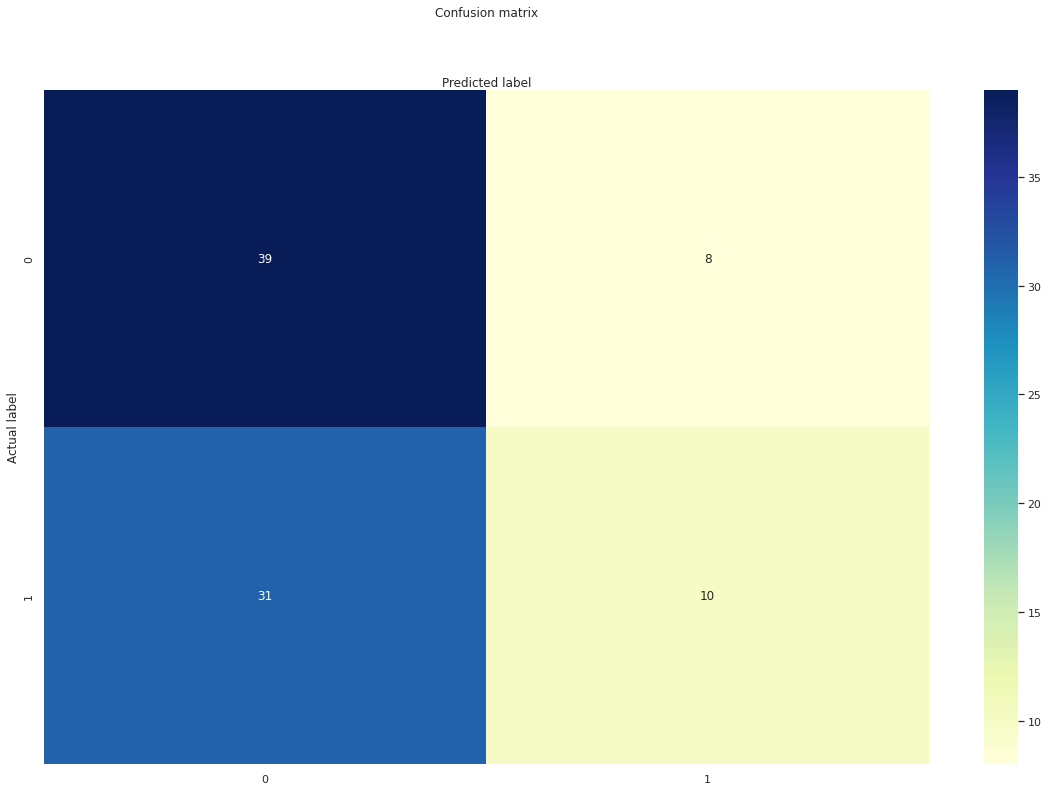

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

In [24]:
from sklearn.metrics import classification_report
target_names = ['Drafted outside the first 3 rounds', 'Successful Draft']
print(classification_report(y_valid, y_pred, target_names=target_names))

                                    precision    recall  f1-score   support

Drafted outside the first 3 rounds       0.56      0.83      0.67        47
                  Successful Draft       0.56      0.24      0.34        41

                          accuracy                           0.56        88
                         macro avg       0.56      0.54      0.50        88
                      weighted avg       0.56      0.56      0.51        88



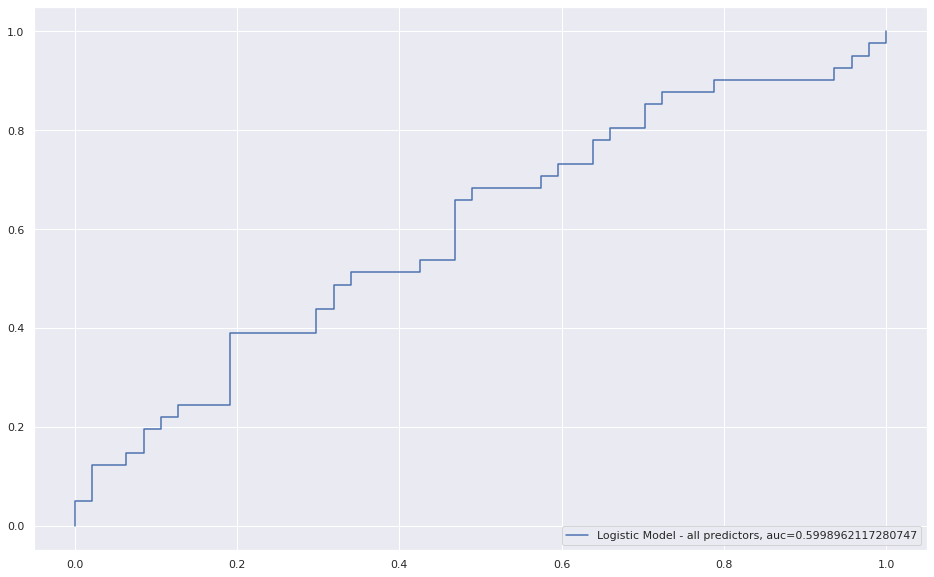

In [25]:
import warnings
warnings.filterwarnings('ignore')

y_pred_proba = logreg.predict_proba(OH_X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid,  y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Model - all predictors, auc="+str(auc))
plt.legend(loc=4)

Our logistic model only predicts with **55 - 57%** accuracy which is...not great... An essentially meaningless classifier (i.e., coin flip) would be 50% accurate. Let's keep going to see what we can do to improve it. 

Maybe we bring in the big guns...

## Model 2: Random Forest Regression

This is getting into territory beyond my expertise and training, so this is purely exploratory. Treat it as though I am building the plane while it's flying type of situation. I am an ML beginner so I welcome any and all feedback here (or elsewhere in the project!).

With that said, I do want to push these data to see how well we can predict draft success with our given features. 

In [26]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(OH_X_train, y_train)

y_pred=clf.predict(OH_X_valid)

In [27]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.6363636363636364


Looks like we've improved our prediction (albeit marginally). We can dig further and look at feature importance to select more vs. less important features to draft success in our data.

In [28]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [29]:
feature_imp = pd.Series(clf.feature_importances_,index=OH_X_train.columns).sort_values(ascending=False)
feature_imp

totalPPA.all           0.113893
career_totalPPA        0.108788
comp_recruit_rating    0.089697
rank                   0.086878
countablePlays         0.085702
averagePPA.all         0.085370
id                     0.083917
ident                  0.083657
career_avgPPA          0.078327
recruit_year           0.040038
draft_year             0.039337
season                 0.026243
stars                  0.020204
4                      0.011860
9                      0.008692
5                      0.008344
8                      0.006778
10                     0.006670
3                      0.005516
7                      0.004425
2                      0.003941
1                      0.000880
0                      0.000588
6                      0.000255
dtype: float64

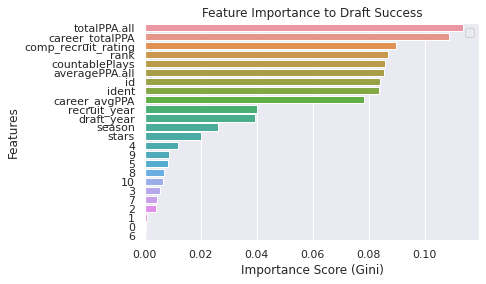

In [30]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

sns.set(rc={"figure.figsize": (28, 14)})

# Add labels to your graph
plt.xlabel('Importance Score (Gini)')
plt.ylabel('Features')
plt.title("Feature Importance to Draft Success")
plt.legend()
plt.show()

Could we improve our model by removing some of the not-so-important features? Well, that depends. Do we want to remove things (not meaningful to the model) that otherwise might make sense for us to include? In biostatistics, we consider these features "clinically meaningful." Something may not make sense statistically, but sometimes clinicians want to know how certain variables relate to the outcome regardless. 

**Let's see if we can't balance the two approaches and optimize our RF.**

In [31]:
# remove what is not statistically important as well as logistically (ID should'nt really matter for example)
X_trimmed = OH_X_train.drop(['ident', 'id', 'season', 'recruit_year'], axis = 1)
X_valid_trimmed = OH_X_valid.drop(['ident', 'id', 'season', 'recruit_year'], axis = 1)

In [32]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_trimmed,y_train)

# prediction on test set
y_pred=clf.predict(X_valid_trimmed)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.5909090909090909


We do not see any improvement in model accuracy from removing the less important features 

## Model 3: Best Logistic Model to Interpret Individual Features

Lastly, we circle back to the logistic model for ease of interpretation and to check the validity of our original hypothesis that composite rating would significantly predict draft success. We start with our most parsimonious model and check if it's a significant predictor. We can also see if other variables/features we've included are significant predictors of draft success, holding all else (including recruit ratings) constant. 

In [33]:
log_mod1 = sm.Logit(y_train, OH_X_train).fit()

log_mod1.summary()

         Current function value: 0.572043
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          draft_success   No. Observations:                  351
Model:                          Logit   Df Residuals:                      328
Method:                           MLE   Df Model:                           22
Date:                Fri, 11 Nov 2022   Pseudo R-squ.:                  0.1629
Time:                        18:18:30   Log-Likelihood:                -200.79
converged:                      False   LL-Null:                       -239.86
Covariance Type:            nonrobust   LLR p-value:                 3.254e-08
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ident               -3.301e-06   2.13e-05     -0.155      0.877    -4.5e-05    3.84e-05
rank                   -0.0002      0.000     -0.487      0.626      -0.001       0.001
recruit_year            0.5142      0.197      2.607      0.009       0.128       0.901
comp_recruit_rating     1.2089      6.800      0.178      0.859     -12.119      14.537
stars                   0.2269      0.423      0.536      0.592      -0.603       1.057
draft_year             -0.1937      0.153     -1.263      0.206      -0.494       0.107
id                  -1.009e-08   1.78e-07     -0.057      0.955   -3.58e-07    3.38e-07
countablePlays         -0.0051      0.003     -2.052      0.040      -0.010      -0.000
averagePPA.all          0.6820      0.511      1.336      0.182      -0.319       1.683
totalPPA.all            0.0219      0.008      2.913      0.004       0.007       0.037
season                 -0.2273      0.239     -0.951      0.341      -0.696       0.241
career_avgPPA          -0.4826      0.318     -1.517      0.129      -1.106       0.141
career_totalPPA         0.0057      0.002      2.978      0.003       0.002       0.010
0                     -91.1487   5.85e+06  -1.56e-05      1.000   -1.15e+07    1.15e+07
1                     -96.0405    5.9e+06  -1.63e-05      1.000   -1.16e+07    1.16e+07
2                    -117.8232   5.85e+06  -2.01e-05      1.000   -1.15e+07    1.15e+07
3                     -64.9038   5.85e+06  -1.11e-05      1.000   -1.15e+07    1.15e+07
4                     -69.6942   5.85e+06  -1.19e-05      1.000   -1.15e+07    1.15e+07
5                     -92.0482   5.85e+06  -1.57e-05      1.000   -1.15e+07    1.15e+07
6                    -118.0599   5.91e+06     -2e-05      1.000   -1.16e+07    1.16e+07
7                     -72.5225   5.85e+06  -1.24e-05      1.000   -1.15e+07    1.15e+07
8                    -124.5239   5.85e+06  -2.13e-05      1.000   -1.15e+07    1.15e+07
9                    -118.9202   5.85e+06  -2.03e-05      1.000   -1.15e+07    1.15e+07
10                    -97.6324   5.85e+06  -1.67e-05      1.000   -1.15e+07    1.15e+07
=======================================================================================
"""

## Conclusions
#### 1) A recruit's composite rating is maybe *least* predictive of draft success among our data. 
Instead, it seems that **player usage (i.e., "countable plays," *p* < 0.05) total Predicted Points Added over the course of a career (*p* < 0.01) and in a season (*p* < 0.01) may be the most predictive.** Our model was broadly significant so we are warranted to make interpretations of findings.

#### 2) We have a *relatively poor R-squared (0.16),* so we can't explain too much of draft success from these data despite a globally significant F-value (LLR *p* < 0.0001). 
We got as high as **60% accurate with our best RF model.** But all that together seems like an interesting result to me. Think of what all we threw at it: recruiting data, advanced player metrics, and draft information - yet we still have lots of explaining to do! This could indicate that we are generally poorer at evaluating talent than we think, although there were some yearly trends to indicate that may be changing. 

We also could bring in more relevant data to expand the variation in metrics. PPA scores are distillations of many variables and player stats, and any time you aggregate you lose some variance that could explain an outcome. 

Needless to say we aren't running our own NIL consulting firm (yet) with this model, but we could always improve!

What do you think? Looking forward to any follow-up analyses and feedback. 

**P.S. If you fork, copy or reference any of this analysis, please attribute credit where due. We're all here to learn and I know I learned alot from example notebooks from folks at CFB data (shout out Bill and Bud), Datacamp, Kaggle Learn. Pay it forward and backward as you go!**

In [34]:
end = time.time()
print('Time elapsed (s): ', round(end - start, 1))

Time elapsed (s):  13.2


If you have any comments or suggestions, I am always looking to improve and collaborate! This is my first Kaggle personal project, after all. 

Please feel free to email me at <blackstonjw@icloud.com>